In [1]:
# !git clone https://github.com/CamiloMartinezM/ultralytics.git
# %cd /content/ultralytics
# !pip install -e .
# !pip install roboflow
# !pip install -U transformers
# !pip install datasets
# !pip install wandb
# !pip install accelerate -U
# !pip install python-dotenv
# %cd /content

In [3]:
import os
import shutil
from datetime import datetime
from gc import collect as garbage_collect
from warnings import warn
import wandb
import copy

import torch
import yaml
from datasets import load_dataset
from dotenv import load_dotenv
from roboflow import Roboflow
from torch.cuda import empty_cache as cuda_empty_cache
from torch.cuda import mem_get_info
from ultralytics import YOLO
from wandb.integration.ultralytics import add_wandb_callback

load_dotenv()  # load environment variables stored in .env file (e.g., API keys)

# Useful constants
CURRENT_DIR = os.getcwd()
DATASETS_DIR = os.path.join(CURRENT_DIR, "data")

# Useful functions


def clean_cache():
    """Cleans the GPU memory cache."""
    garbage_collect()
    cuda_empty_cache()
    mem_info = mem_get_info()
    print(
        f"Freeing GPU Memory\nFree: %d MB\tTotal: %d MB"
        % (mem_info[0] // 1024**2, mem_info[1] // 1024**2)
    )


def safe_save(model: torch.nn.Module, final_model_path: str) -> None:
    """Saves a model to a file, ensuring that the file does not already exist. If it does, it
    renames the existing file."""
    # Ensure the directory exists
    os.makedirs(os.path.dirname(final_model_path), exist_ok=True)

    if os.path.exists(final_model_path):
        # Get current timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H_%M_%S")

        # Split the path into directory, filename, and extension
        directory, filename = os.path.split(final_model_path)
        name, ext = os.path.splitext(filename)

        # Create new filename with timestamp
        new_filename = f"{name}_{timestamp}{ext}"
        new_path = os.path.join(directory, new_filename)

        warn(f"{final_model_path} already exists. Renaming existing file to: {new_filename}")

        # Rename the existing file
        shutil.move(final_model_path, new_path)

    # Save the new model
    model.save(final_model_path)
    print(f"New model saved as: {final_model_path}")


def load_config(config_path: str) -> dict:
    """Loads a YAML config file."""
    with open(config_path, "r") as file:
        return yaml.safe_load(file)


def to_path(*args):
    """Converts a list of strings into a path, from the current directory saved in `CURRENT_DIR`."""
    # If "/" is present in one of the strings, it is separated into a list of strings, such that we
    # use the safe `os.path.join` function.
    path_parts = []
    for arg in args:
        if '/' in arg:
            path_parts.extend(arg.split('/'))
        else:
            path_parts.append(arg)

    return os.path.join(CURRENT_DIR, *path_parts)


def download_from(config: dict) -> None:
    """Downloads a dataset using the loaded `config`. It must have the following structure:

    ```
    data:
        dataset: e.g., "guitar-necks-detector" or "dduka/guitar-chords" # The name of the dataset
        load:
            interface: "roboflow" or "datasets"
            # (These must be available only if interface is "roboflow":)
            workspace: "..."
            project-version: "1"
            version-download: "..."
    ```
    """
    if config["data"]["load"]["interface"] == "roboflow":
        # Test if a ROBOFLOW_API_KEY is available
        if not os.getenv("ROBOFLOW_API_KEY"):
            from importlib.util import find_spec

            if find_spec("google"):
                from google.colab import userdata
                if userdata.get("ROBOFLOW_API_KEY"):
                    os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")
            else:
                raise ValueError(
                    "ROBOFLOW_API_KEY is not available in the environment variables. "
                    + "Create a .env file in this directory with the key or in Google "
                    + "Colab, add it to secret keys."
                )

        # Initialize Roboflow
        rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))

        # Access the workspace and project
        project = rf.workspace(config["data"]["load"]["workspace"]).project(
            config["data"]["dataset"]
        )
        version = project.version(config["data"]["load"]["project-version"])
        dataset_path = os.path.join(DATASETS_DIR, config["data"]["dataset"])
        ds = version.download(config["data"]["load"]["version-download"], location=dataset_path)
    elif config["data"]["load"]["interface"] == "datasets":
        dataset_path = os.path.join(DATASETS_DIR, config["data"]["dataset"])
        ds = load_dataset("dduka/guitar-chords", cache_dir=dataset_path)

    return ds, dataset_path

wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


In [4]:
FINAL_MODELS_DIR = to_path("final_models")
ORIGINAL_MODELS_DIR = to_path("original_models")
IMAGES_DIR = to_path("images")

In [5]:
f_run_config = "config-yolo-v9.yml"
f_wandb_config = "wandb.yml"

In [6]:
# Load configuration
config = load_config(to_path(f_run_config))
wandb_config = load_config(to_path(f_wandb_config))

## **Training on Fretboard Dataset**

In [7]:
# Load the ds
dataset, dataset_path = download_from(config)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/data/guitar-necks-detector in coco:: 100%|██████████| 1032/1032 [00:00<00:00, 6471.06it/s]


In [ ]:
# Initialize the model
model = YOLO(str(config['model']['name']))

In [ ]:
# Keep a copy of old state dict for sanity check
old_dict = copy.deepcopy(model.state_dict())

# We should freeze all but the last layer
# Print the keys of the state dictionary
print(list(model.state_dict().keys()))

['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.0.cv1.conv.weight', 'model.model.2.cv2.0.cv1.bn.weight', 'model.model.2.cv2.0.cv1.bn.bias', 'model.model.2.cv2.0.cv1.bn.running_mean', 'model.model.2.cv2.0.cv1.bn.running_var', 'model.model.2.cv2.0.cv1.bn.num_batches_tracked', 'model.model.2.cv2.0.cv2.conv.weight', 'model.model.2.cv2.0.cv2.bn.weight', 'model.model.2.cv2.0.cv2.bn.bias', 'model.model.2.cv2.0.cv2.bn.running_mean', 'model.model.2.cv

In [ ]:
# Add a callback to put the frozen layers in eval mode to prevent BN values
# from changing.
def put_in_eval_mode(trainer, n_layers=22):
    for i, (name, module) in enumerate(trainer.model.named_modules()):
        if name.endswith("bn") and int(name.split('.')[1]) < n_layers:
            module.eval()
            module.track_running_stats = False
      # print(name, " put in eval mode.")

In [ ]:
model.add_callback("on_train_epoch_start", put_in_eval_mode)
model.add_callback("on_pretrain_routine_start", put_in_eval_mode)

In [ ]:
# Disable wandb for testing
# wandb.init(mode="disabled")

# Initialize wandb
wandb.require("core")
wandb.init(
    project=wandb_config["project"],
    name=wandb_config["name"] + "-" + wandb.util.generate_id(),
    config=wandb_config,
    entity=wandb_config["entity"],
)

# Add W&B callback for Ultralytics
# add_wandb_callback(model, enable_model_checkpointing=True)

# Train the model
results = model.train(
    data=f"{dataset_path}/data.yaml",
    imgsz=config["training"]["imgsz"],
    epochs=config["training"]["epochs"],
    freeze=22,
)

new_state_dict = dict()

#  Increment the head number by 1 in the state_dict
for k, v in model.state_dict().items():
    if k.startswith("model.model.22"):
        new_state_dict[k.replace("model.22", "model.23")] = v
# else:
#   new_state_dict[k] = v

# Save the current state_dict
torch.save(new_state_dict, f"{config["model"]["name"]}_lp.pth")

wandb.finish()

Ultralytics YOLOv8.2.60 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/guitar-necks-detector/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=22, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 94.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 261MB/s]


AMP: checks passed ✅


train: Scanning /content/guitar-necks-detector/train/labels... 921 images, 0 backgrounds, 0 corrupt: 100%|██████████| 921/921 [00:00<00:00, 1559.59it/s]


train: New cache created: /content/guitar-necks-detector/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1119, len(boxes) = 1122. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/guitar-necks-detector/valid/labels... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<00:00, 1227.24it/s]

val: New cache created: /content/guitar-necks-detector/valid/labels.cache


Plotting labels to /content/ultralytics/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/ultralytics/runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.17G      1.824      2.698      2.094         17        640: 100%|██████████| 58/58 [00:28<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all         88         94      0.336      0.415       0.33      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.01G      1.859      1.971      2.113         22        640: 100%|██████████| 58/58 [00:24<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         88         94      0.353      0.606      0.382      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.87G      1.775       1.81      2.035         24        640: 100%|██████████| 58/58 [00:25<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         88         94      0.586      0.511      0.569      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.07G      1.717      1.735      2.003         20        640: 100%|██████████| 58/58 [00:24<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         88         94      0.564      0.681      0.668      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.94G      1.645      1.649      1.942         35        640: 100%|██████████| 58/58 [00:22<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         88         94      0.622      0.638      0.708      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.94G        1.6      1.544      1.891         11        640: 100%|██████████| 58/58 [00:24<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all         88         94      0.645      0.596      0.687      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.02G      1.588      1.514       1.89         20        640: 100%|██████████| 58/58 [00:26<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         88         94      0.716      0.725      0.778       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.02G      1.551      1.458      1.862         27        640: 100%|██████████| 58/58 [00:24<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all         88         94      0.563      0.649      0.666      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.94G      1.503      1.424      1.816         26        640: 100%|██████████| 58/58 [00:23<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         88         94      0.738      0.658      0.766      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.94G      1.489      1.385       1.81         23        640: 100%|██████████| 58/58 [00:25<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all         88         94      0.632      0.745      0.779      0.393


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.15G      1.374      1.188      1.865          9        640: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         88         94      0.625      0.745      0.746      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.94G      1.279      1.098       1.79         10        640: 100%|██████████| 58/58 [00:23<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         88         94       0.62       0.85      0.782      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.94G      1.243      1.037      1.753          9        640: 100%|██████████| 58/58 [00:23<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         88         94      0.702      0.734      0.805      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.94G      1.198     0.9684      1.682          9        640: 100%|██████████| 58/58 [00:25<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         88         94      0.717      0.727      0.815      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.25G       1.18     0.9375      1.655          9        640: 100%|██████████| 58/58 [00:22<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         88         94      0.794      0.755      0.839      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.12G      1.145     0.8997      1.642         16        640: 100%|██████████| 58/58 [00:22<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         88         94      0.777      0.777       0.86      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.91G      1.116      0.886      1.627          9        640: 100%|██████████| 58/58 [00:27<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         88         94      0.835      0.752      0.863      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.12G      1.104     0.8748      1.605          9        640: 100%|██████████| 58/58 [00:23<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         88         94      0.809      0.713      0.844      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.91G      1.054     0.8338      1.565         13        640: 100%|██████████| 58/58 [00:23<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         88         94      0.816      0.754      0.866      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.91G      1.053     0.8305      1.587          9        640: 100%|██████████| 58/58 [00:23<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         88         94      0.795      0.798      0.866      0.539



20 epochs completed in 0.162 hours.
Optimizer stripped from /content/ultralytics/runs/detect/train/weights/last.pt, 51.6MB
Optimizer stripped from /content/ultralytics/runs/detect/train/weights/best.pt, 51.6MB

Validating /content/ultralytics/runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.60 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


                   all         88         94      0.824      0.748       0.87      0.548
Speed: 0.3ms preprocess, 15.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/ultralytics/runs/detect/train


F1_curve/height,▁
F1_curve/size,▁
F1_curve/width,▁
PR_curve/height,▁
PR_curve/size,▁
PR_curve/width,▁
P_curve/height,▁
P_curve/size,▁
P_curve/width,▁
R_curve/height,▁
R_curve/size,▁


In [ ]:
def compare_dicts(state_dict1, state_dict2):
    # Compare the keys
    keys1 = set(state_dict1.keys())
    keys2 = set(state_dict2.keys())

    if keys1 != keys2:
        print("Models have different parameter names.")
        return False

    # Compare the values (weights)
    for key in keys1:
        if not torch.equal(state_dict1[key], state_dict2[key]):
            print(f"Weights for parameter '{key}' are different.")
            if "bn" in key and "22" not in key:
              state_dict1[key] = state_dict2[key]

# Compare the dicts. Changes should only be in layer 21 and above
compare_dicts(old_dict, model.state_dict())

Weights for parameter 'model.model.22.cv3.2.1.bn.weight' are different.
Weights for parameter 'model.model.22.cv2.0.1.bn.running_var' are different.
Weights for parameter 'model.model.22.cv3.0.0.bn.running_var' are different.
Weights for parameter 'model.model.22.cv3.1.2.weight' are different.
Weights for parameter 'model.model.22.cv3.1.1.bn.running_var' are different.
Weights for parameter 'model.model.22.cv3.0.2.bias' are different.
Weights for parameter 'model.model.22.cv3.0.0.bn.bias' are different.
Weights for parameter 'model.model.22.cv3.0.0.conv.weight' are different.
Weights for parameter 'model.model.22.cv2.1.1.bn.weight' are different.
Weights for parameter 'model.model.22.cv3.0.1.bn.running_var' are different.
Weights for parameter 'model.model.22.cv2.0.0.conv.weight' are different.
Weights for parameter 'model.model.22.cv3.2.2.bias' are different.
Weights for parameter 'model.model.22.cv3.1.0.conv.weight' are different.
Weights for parameter 'model.model.22.cv2.0.1.conv.we

## **Add New `ConcatHead` Layer**

In [10]:
model_2 = YOLO("yolov9c-2xhead.yaml", task="detect").load(os.path.join(ORIGINAL_MODELS_DIR, "yolov9c.pt"))

Transferred 937/1022 items from pretrained weights


In [11]:
model_2.state_dict().keys()

odict_keys(['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.0.cv1.conv.weight', 'model.model.2.cv2.0.cv1.bn.weight', 'model.model.2.cv2.0.cv1.bn.bias', 'model.model.2.cv2.0.cv1.bn.running_mean', 'model.model.2.cv2.0.cv1.bn.running_var', 'model.model.2.cv2.0.cv1.bn.num_batches_tracked', 'model.model.2.cv2.0.cv2.conv.weight', 'model.model.2.cv2.0.cv2.bn.weight', 'model.model.2.cv2.0.cv2.bn.bias', 'model.model.2.cv2.0.cv2.bn.running_mean', 'model

In [12]:
state_dict = torch.load(os.path.join(FINAL_MODELS_DIR, "yolov9c_lp.pth"))
state_dict.keys()

dict_keys(['model.model.23.cv2.0.0.conv.weight', 'model.model.23.cv2.0.0.bn.weight', 'model.model.23.cv2.0.0.bn.bias', 'model.model.23.cv2.0.0.bn.running_mean', 'model.model.23.cv2.0.0.bn.running_var', 'model.model.23.cv2.0.0.bn.num_batches_tracked', 'model.model.23.cv2.0.1.conv.weight', 'model.model.23.cv2.0.1.bn.weight', 'model.model.23.cv2.0.1.bn.bias', 'model.model.23.cv2.0.1.bn.running_mean', 'model.model.23.cv2.0.1.bn.running_var', 'model.model.23.cv2.0.1.bn.num_batches_tracked', 'model.model.23.cv2.0.2.weight', 'model.model.23.cv2.0.2.bias', 'model.model.23.cv2.1.0.conv.weight', 'model.model.23.cv2.1.0.bn.weight', 'model.model.23.cv2.1.0.bn.bias', 'model.model.23.cv2.1.0.bn.running_mean', 'model.model.23.cv2.1.0.bn.running_var', 'model.model.23.cv2.1.0.bn.num_batches_tracked', 'model.model.23.cv2.1.1.conv.weight', 'model.model.23.cv2.1.1.bn.weight', 'model.model.23.cv2.1.1.bn.bias', 'model.model.23.cv2.1.1.bn.running_mean', 'model.model.23.cv2.1.1.bn.running_var', 'model.model.2

In [13]:
# Load state_dict of the custom trained model head. Layer 23.
model_2.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv2.0.cv1.conv.weight', 'model.model.2.cv2.0.cv1.bn.weight', 'model.model.2.cv2.0.cv1.bn.bias', 'model.model.2.cv2.0.cv1.bn.running_mean', 'model.model.2.cv2.0.cv1.bn.running_var', 'model.model.2.cv2.0.cv2.conv.weight', 'model.model.2.cv2.0.cv2.bn.weight', 'model.model.2.cv2.0.cv2.bn.bias', 'model.model.2.cv2.0.cv2.bn.running_mean', 'model.model.2.cv2.0.cv2.bn.running_var', 'model.model.2.cv2.0.cv3.conv.weight', 'model.model.2.cv2.0.cv3.bn.weight', 'model.model.2.cv2.0.cv3.bn.bias', 'model.

In [26]:
# Output of COCO model
model_coco = YOLO(os.path.join(ORIGINAL_MODELS_DIR, "yolov9c.pt"))

# For consistency
model_coco.model.names = {k:k for k in model_coco.names.keys()}

result_coco = model_coco.predict(os.path.join(IMAGES_DIR, "test-coco.jpg"))[0]


image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/images/test-coco.jpg: 480x640 3 0s, 1 5, 1 9, 13.5ms
Speed: 1.1ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


In [27]:
# Output of custom LP model
model_lp = YOLO(os.path.join(FINAL_MODELS_DIR, "best.pt"))

# For plotting consistency, change all class names to class numbers
model_lp.model.names = {k:k for k in model_lp.names.keys()}

result_lp = model_lp.predict(os.path.join(IMAGES_DIR, "test-coco.jpg"))[0]


image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/images/test-coco.jpg: 480x640 (no detections), 13.3ms
Speed: 1.1ms preprocess, 13.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


In [29]:
# Output of the new model
result_merged = model_2.predict(os.path.join(IMAGES_DIR, "test-coco.jpg"))[0]
result_merged2 = model_2.predict(os.path.join(IMAGES_DIR, "test-fretboard.jpeg"))[0]


image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/images/test-coco.jpg: 480x640 3 0s, 1 5, 1 9, 22.6ms
Speed: 2.1ms preprocess, 22.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/images/test-fretboard.jpeg: 384x640 1 0, 1 80, 265.8ms
Speed: 1.4ms preprocess, 265.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


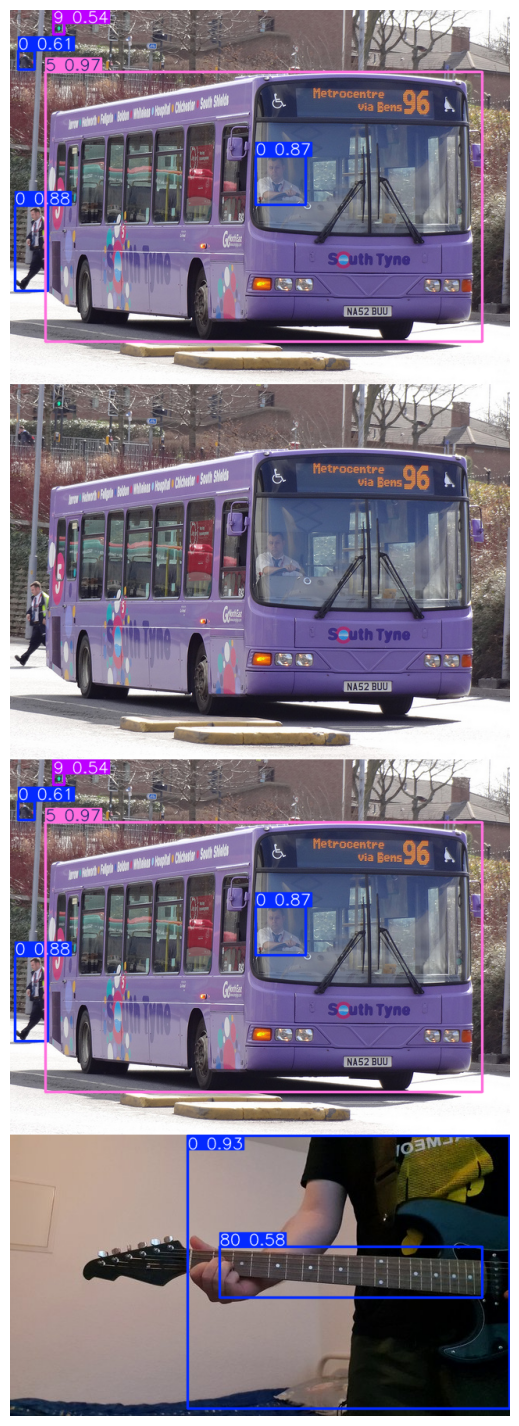

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def show_output(images):
    image = np.vstack(images)
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    fig.set_size_inches((5,15))
    ax.imshow(image[...,::-1])

show_output([result_coco.plot(), result_lp.plot(), result_merged.plot(), result_merged2.plot()])

In [32]:
model_coco.names

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '10',
 11: '11',
 12: '12',
 13: '13',
 14: '14',
 15: '15',
 16: '16',
 17: '17',
 18: '18',
 19: '19',
 20: '20',
 21: '21',
 22: '22',
 23: '23',
 24: '24',
 25: '25',
 26: '26',
 27: '27',
 28: '28',
 29: '29',
 30: '30',
 31: '31',
 32: '32',
 33: '33',
 34: '34',
 35: '35',
 36: '36',
 37: '37',
 38: '38',
 39: '39',
 40: '40',
 41: '41',
 42: '42',
 43: '43',
 44: '44',
 45: '45',
 46: '46',
 47: '47',
 48: '48',
 49: '49',
 50: '50',
 51: '51',
 52: '52',
 53: '53',
 54: '54',
 55: '55',
 56: '56',
 57: '57',
 58: '58',
 59: '59',
 60: '60',
 61: '61',
 62: '62',
 63: '63',
 64: '64',
 65: '65',
 66: '66',
 67: '67',
 68: '68',
 69: '69',
 70: '70',
 71: '71',
 72: '72',
 73: '73',
 74: '74',
 75: '75',
 76: '76',
 77: '77',
 78: '78',
 79: '79'}

In [31]:
model_2.names

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '10',
 11: '11',
 12: '12',
 13: '13',
 14: '14',
 15: '15',
 16: '16',
 17: '17',
 18: '18',
 19: '19',
 20: '20',
 21: '21',
 22: '22',
 23: '23',
 24: '24',
 25: '25',
 26: '26',
 27: '27',
 28: '28',
 29: '29',
 30: '30',
 31: '31',
 32: '32',
 33: '33',
 34: '34',
 35: '35',
 36: '36',
 37: '37',
 38: '38',
 39: '39',
 40: '40',
 41: '41',
 42: '42',
 43: '43',
 44: '44',
 45: '45',
 46: '46',
 47: '47',
 48: '48',
 49: '49',
 50: '50',
 51: '51',
 52: '52',
 53: '53',
 54: '54',
 55: '55',
 56: '56',
 57: '57',
 58: '58',
 59: '59',
 60: '60',
 61: '61',
 62: '62',
 63: '63',
 64: '64',
 65: '65',
 66: '66',
 67: '67',
 68: '68',
 69: '69',
 70: '70',
 71: '71',
 72: '72',
 73: '73',
 74: '74',
 75: '75',
 76: '76',
 77: '77',
 78: '78',
 79: '79',
 80: '80'}